In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import schemdraw
import schemdraw.elements as elm
sp.init_printing()
%matplotlib inline

A resistor devider is needed to lower the voltage level of the amplifier command voltage used for lab 4 to a lower voltage. The design of this divider must take into account both the output impedance and the pulldown resistor of the myRIO, and the input impedance of the amplifer.

However, first the output impedance of the myRIO must be estimated as it is not specified. The myRIO output pin can be modelled as an output impedance and a pulldown resistor, as shown.

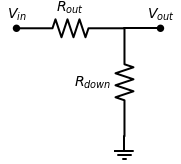

In [2]:
d = schemdraw.Drawing()
d.add(elm.Dot(at=(0, 0), label="$V_{in}$"))
d.add(elm.Resistor(d='r', label="$R_{out}$"))
d.add(elm.Line(d='r', l=1))
d.add(elm.Dot(label="$V_{out}$"))
d.add(elm.Resistor(d='d', at=(3, 0), label="$R_{down}$"))
d.add(elm.Ground())
d.draw()

When measured, the input to this voltage divider is:

In [3]:
Vin = 3.25 # Volts

The myRIO specifications show a pulldown resistor of:

In [4]:
Rdown = 40_000 # Ohms

When floating, the myRIO output pin is left floating, the output voltage is:

In [5]:
Vout_float = 3.1 # Volts

Using this information, the output impedance can be calculated from the equation,

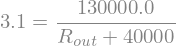

In [6]:
sp.var("R_out")
myRIO_divider = sp.Eq(Vout_float, Vin * Rdown / (Rdown + R_out))
myRIO_divider

Now solving for $R_{out}$,

In [7]:
sols = sp.solve(myRIO_divider, R_out)
assert len(sols) == 1
sol = sols[0]
Rout = float(sol)
print(f"Output impedance: {Rout} Ohms.")

Output impedance: 1935.483870967742 Ohms.


We can now begin the analysis of the full circuit, as shown below.

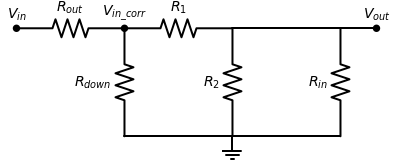

In [8]:
d = schemdraw.Drawing()
d.add(elm.Dot(at=(0, 0), label="$V_{in}$"))
d.add(elm.Resistor(d='r', label="$R_{out}$"))
d.add(elm.Dot(d='r', label="$V_{in\_corr}$"))
d.add(elm.Resistor(d='r', label="$R_1$"))
d.add(elm.Line(d='r'))
d.add(elm.Resistor(d='d', label="$R_{in}$"))
d.add(elm.Line(d='l'))
d.add(elm.Ground())
d.add(elm.Resistor(d='d', at=(3, 0), label="$R_{down}$"))
d.add(elm.Line(d='r'))
d.add(elm.Resistor(d='u', label="$R_2$"))
d.add(elm.Line(d='r', at=(9, 0), l=1))
d.add(elm.Dot(label="$V_{out}$"))
d.draw()

In this circuit, the values of one more resistor is known.

In [9]:
Rin = 100_000 # Ohms

To find $V_{out}$, we begin with the desired current:

In [10]:
Iout = 0.05 # Amps

Since the amplifier gain is:

In [11]:
Ka = 0.06 # A / V

Therefore, the desired voltage is:

In [12]:
Vout = Iout / Ka
print(f"{Vout} Volts")

0.8333333333333334 Volts


Using these values, we can now begin to solve for $R_1$ and $R_2$.

In [13]:
sp.var("R_1 R_2")

The amplifier input impedance ($R_{in}$) and the second resistor of the divider ($R_2$) can be combined together:

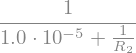

In [14]:
R_2_in = 1 / (1 / R_2 + 1 / Rin)
R_2_in

Similarly, this can be combined with the first resitor of the divider, $R_1$.

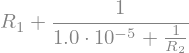

In [15]:
R_12_in = R_1 + R_2_in
R_12_in

Finally, $R_{down}$ can be included.

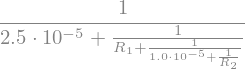

In [16]:
R_down_12_in = 1 / (1 / Rdown + 1 / R_12_in)
R_down_12_in

This has simlified the schematic to the following.

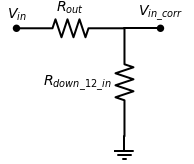

In [17]:
d = schemdraw.Drawing()
d.add(elm.Dot(at=(0, 0), label="$V_{in}$"))
d.add(elm.Resistor(d='r', label="$R_{out}$"))
d.add(elm.Line(d='r', l=1))
d.add(elm.Dot(label=r"$V_{in\_corr}$"))
d.add(elm.Resistor(d='d', at=(3, 0), label=r"$R_{down\_12\_in}$"))
d.add(elm.Ground())
d.draw()

Therefore, $V_{in\_corr}$ can be calculated:

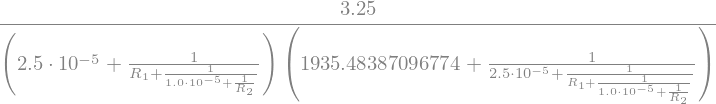

In [18]:
V_in_corr = Vin * R_down_12_in / (R_down_12_in + Rout)
V_in_corr

This can be used to simplify the schematic to:

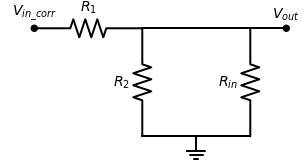

In [19]:
d = schemdraw.Drawing()
d.add(elm.Dot(at=(0, 0), label=r"$V_{in\_corr}$"))
d.add(elm.Resistor(d='r', label="$R_1$"))
d.add(elm.Line(d='r', l=4))
d.add(elm.Dot(label=r"$V_{out}$"))
d.add(elm.Resistor(d='d', at=(3, 0), label=r"$R_2$"))
d.add(elm.Line(d='r', l=1.5))
d.add(elm.Ground())
d.add(elm.Resistor(d='d', at=(6, 0), label="$R_{in}$"))
d.add(elm.Line(d='l', l=1.5))
d.draw()

The equation for the output voltage $V_{out}$ can now be written,

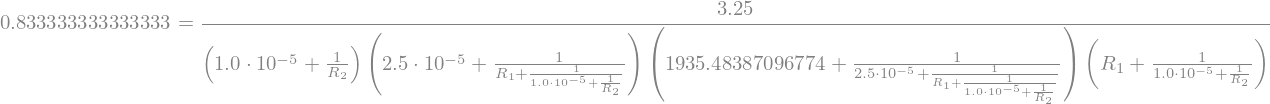

In [20]:
divider = sp.Eq(Vout, V_in_corr * R_2_in / (R_2_in + R_1))
divider

This equation can now be solved for $R_1$.

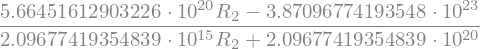

In [21]:
sols = sp.solve(divider, R_1)
assert len(sols) == 1
sol = sols[0]
sol

A function now can be created for finding $R_1$ from $R_2$.

In [22]:
calc_R1 = sp.lambdify(R_2, sol)

The hard part about this design problem is the resistor choices are limited. Resistors are primarily only available in the E-series:

In [23]:
Eseries = np.array([1, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2])

@np.vectorize
def find_closest(value):
  assert value > 0
  series = np.hstack([Eseries, 10 * Eseries])
  while True:
    if value > series.max():
      series *= 10
    elif value < series.min():
      series /= 10
    else:
      break
  return series[np.abs(series - value).argmin()]
  

We can assume values for R2, then solve for R1.

In [24]:
R2 = 1000 * Eseries
R2

array([1000., 1200., 1500., 1800., 2200., 2700., 3300., 3900., 4700.,
       5600., 6800., 8200.])

We can now solve for the value of the R1, given R2:

In [25]:
R1 = find_closest(calc_R1(R2))
print(R1)

[  820.  1500.  2200.  2700.  3900.  5600.  6800.  8200. 10000. 12000.
 15000. 18000.]


In [26]:
calc_V_out = sp.lambdify((R_1, R_2), divider.rhs)

We can now find the output of each divider:

In [27]:
Vout_act = calc_V_out(R1, R2)
Vout_act

array([0.83946791, 0.81110999, 0.82934325, 0.86807924, 0.84483636,
       0.80891449, 0.8363667 , 0.84321655, 0.85190116, 0.85849057,
       0.85028483, 0.8566555 ])

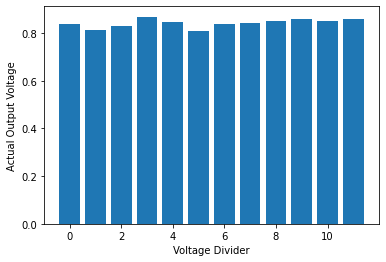

In [28]:
plt.bar(range(Vout_act.size), Vout_act)
plt.ylabel("Actual Output Voltage")
plt.xlabel("Voltage Divider");

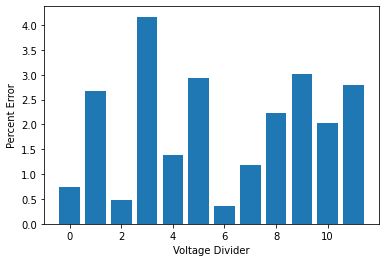

In [29]:
percent_error = 100 * np.abs((Vout_act - Vout) / Vout)
plt.bar(range(percent_error.size), percent_error)
plt.ylabel("Percent Error")
plt.xlabel("Voltage Divider");

The best resistor divider is:

In [30]:
best = percent_error.argmin()
best

6

This resistor divider is composed of resistors with values:

In [31]:
print(f"{R1[best]} and {R2[best]} ohms")

6800.0 and 3300.0 ohms


It results in an output voltage of:

In [32]:
Vout_act[best]

Which has a percent error of:

In [33]:
print(f"{percent_error[best]}%")

0.36400409536051725%


Using these equations, the old amplifier input voltage is estimated at:

In [34]:
print(f"{calc_V_out(22000, 8200)} Volts")

0.7476132301705808 Volts


Which is close to the measured 7.6 Volts